In [185]:
DATA_TRAIN_PROCESSED = '../data/prepocessed/train.csv'
LOG_RESULTS = '../models/log/metrics_results.csv'
REPORT = '../reports/results/'

# Import

In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

In [187]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Define

## Outliers

In [188]:
def anomaly_detection_boxplot(data):
    """
    Phát hiện và vẽ boxplot để kiểm tra outliers trong dữ liệu.
    
    Parameters:
        data (pd.Series or list): Dữ liệu đầu vào
        
    Returns:
        outliers (list): Danh sách outliers
    """
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outlier_indices = (data < lower_bound) | (data > upper_bound)
    
    outliers = pd.DataFrame({'Value': data[outlier_indices]})

    plt.figure(figsize=(12, 6))
    plt.plot(data, label="Series", color='blue', alpha=0.7)
    
    plt.scatter(outliers.index, outliers['Value'], color='red', label="Outliers", zorder=3)
    
    plt.xlabel("Time")
    plt.ylabel("Tempurature")
    plt.legend()
    plt.show()
    
    print(f"Detected {len(outliers)} outliers.")
    return outliers

In [189]:
def anomaly_detection_rolling(data, window_size=20, threshold=3):
    """
    Phát hiện bất thường trong chuỗi thời gian bằng rolling mean và rolling std.

    Parameters:
        data (pd.Series): Chuỗi dữ liệu gốc.
        window_size (int): Kích thước cửa sổ trượt.
        threshold (float): Ngưỡng phát hiện outliers (số lần độ lệch chuẩn).

    Returns:
        outliers (pd.DataFrame): DataFrame chứa index và giá trị của outliers.
    """
    rolling_mean = data.rolling(window=window_size).mean()
    rolling_std = data.rolling(window=window_size).std()

    # Xác định ngưỡng trên và dưới
    upper_bound = rolling_mean + threshold * rolling_std
    lower_bound = rolling_mean - threshold * rolling_std

    # Xác định các điểm bất thường
    outlier_indices = (data > upper_bound) | (data < lower_bound)
    outliers = data[outlier_indices]

    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))
    plt.plot(data, label="Original Data", color='blue', alpha=0.7)
    plt.plot(rolling_mean, label=f"Rolling Mean (window={window_size})", color='green', linestyle="--")
    plt.fill_between(data.index, lower_bound, upper_bound, color='gray', alpha=0.3, label="Threshold Range")
    plt.scatter(outliers.index, outliers, color='red', label="Outliers", zorder=3)

    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(f"Anomaly Detection using Rolling Mean & Std (window={window_size}, threshold={threshold})")
    plt.legend()
    plt.show()

    print(f"Detected {len(outliers)} outliers.")
    return outliers.to_frame(name="Value")

In [190]:
def replace_and_fill_outliers(data, outliers, method="interpolate"):
    """
    Thay thế outliers trong Series bằng NaN và điền lại bằng các phương pháp khác nhau.
    Vẽ biểu đồ trước và sau khi xử lý, đánh dấu những điểm đã thay thế.

    Parameters:
        data (pd.Series): Chuỗi dữ liệu gốc (index dạng DatetimeIndex).
        outliers (pd.DataFrame): DataFrame chứa outliers (index có thể khác `data.index`).
        method (str): Phương pháp điền giá trị ['mean', 'backward', 'forward', 'interpolate'].

    Returns:
        pd.Series: Chuỗi đã xử lý outliers.
    """
    # Đảm bảo index của `outliers` có trong `data`
    valid_outliers_idx = outliers.index.intersection(data.index)

    if len(valid_outliers_idx) == 0:
        print("Không có outlier nào có index khớp với dữ liệu gốc.")
        return data  # Trả về dữ liệu ban đầu nếu không có gì để thay thế

    # Tạo bản sao dữ liệu gốc
    cleaned_data = data.copy()

    # Thay thế giá trị outliers bằng NaN
    cleaned_data.loc[valid_outliers_idx] = np.nan

    # Điền giá trị theo phương pháp đã chọn
    if method == "mean":
        filled_data = cleaned_data.fillna(cleaned_data.mean())
    elif method == "backward":
        filled_data = cleaned_data.fillna(method="bfill")
    elif method == "forward":
        filled_data = cleaned_data.fillna(method="ffill")
    elif method == "interpolate":
        filled_data = cleaned_data.interpolate(method="linear")  # Chỉnh lại phương pháp nội suy
    else:
        raise ValueError("Phương pháp điền giá trị không hợp lệ. Chọn một trong ['mean', 'backward', 'forward', 'interpolate']")

    # Vẽ biểu đồ so sánh trước và sau khi xử lý
    plt.figure(figsize=(12, 6))
    plt.plot(data, label="Original Data", color='blue', alpha=0.6)
    plt.plot(filled_data, label="Cleaned Data", color='green', linestyle="--")
    plt.scatter(valid_outliers_idx, data.loc[valid_outliers_idx], color='red', label="Replaced Outliers", zorder=3)

    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(f"Outlier Replacement using {method} method")
    plt.legend()
    plt.show()

    print(f"Replaced {len(valid_outliers_idx)} outliers using '{method}' method.")
    return filled_data


## Model

In [191]:
class ARIMAModel:
    def __init__(self, train_data):
        """
        Khởi tạo mô hình ARIMA.

        :param train_data: Dữ liệu huấn luyện (chuỗi thời gian).
        """
        self.train_data = train_data
        self.model = None
        self.order = None

    def fit(self, p=None, d=None, q=None):
        """
        Huấn luyện mô hình ARIMA với các tham số chỉ định hoặc tìm tham số tối ưu.

        Args:
            p (int, optional): Giá trị của tham số p (số lượng bậc trễ của phần AR).
            d (int, optional): Giá trị của tham số d (số lần sai phân để làm dừng dữ liệu).
            q (int, optional): Giá trị của tham số q (số lượng bậc trễ của phần MA).

        Những tham số nào được truyền vào sẽ cố định, các tham số còn lại sẽ được tối ưu tự động.
        """
        self.model = auto_arima(
            self.train_data,
            p=p if p is not None else 0, max_p=p if p is not None else 5,
            d=d if d is not None else 0, max_d=d if d is not None else 2,
            q=q if q is not None else 0, max_q=q if q is not None else 5,
            stepwise=True,
            seasonal=False,
            trace=True
        )

        print(f"Best params: {self.model.summary()}")
        self.order = self.model.order  



    def predict(self, length):
        """
        Dự báo nhiều bước phía trước.

        :param length: Số bước cần dự báo.
        :return: DataFrame chứa giá trị dự báo và khoảng tin cậy.
        """
        if self.model is None:
            raise ValueError("Model has not been trained yet. Please call fit() before predicting.")

        forecast, conf_int = self.model.predict(n_periods=length, return_conf_int=True)

        return np.array(forecast), np.array(conf_int) 


## Task

In [192]:
def normalize_data(data, method="minmax"):
    """Chuẩn hóa dữ liệu theo phương pháp MinMax hoặc StandardScaler."""
    if method == "minmax":
        scaler = MinMaxScaler(feature_range=(0, 1))
    elif method == "standard":
        scaler = StandardScaler()
    else:
        return data, None

    data_scaled = scaler.fit_transform(np.array(data).reshape(-1, 1))
    return data_scaled, scaler

In [193]:
def inverse_scale(data_scaled, scaler):
    """
    Đảo ngược quá trình chuẩn hóa dữ liệu.

    Parameters:
        data_scaled (np.array): Dữ liệu đã được chuẩn hóa.
        scaler: Đối tượng scaler đã sử dụng để chuẩn hóa dữ liệu.

    Returns:
        np.array: Dữ liệu gốc sau khi đảo ngược chuẩn hóa.
    """
    if scaler is None:
        return data_scaled  
    data_original = scaler.inverse_transform(np.array(data_scaled).reshape(-1, 1))
    return data_original.flatten()

In [194]:
def plot_forecast(train_data, y_test, y_pred, model, index, conf_int=None):
    """
    Vẽ và lưu biểu đồ dự báo.

    Args:
        train_data (pd.Series): Dữ liệu huấn luyện.
        y_test (pd.Series): Dữ liệu thực tế.
        y_pred (np.array): Giá trị dự báo.
        model: Đối tượng model đã được huấn luyện (có thuộc tính `__class__.__name__`).
        index (int): Index của dòng metrics đã lưu.
        conf_int (np.array, optional): Khoảng tin cậy của dự báo.
    """
    plt.figure(figsize=(12, 6))

    train_index = train_data.index
    test_index = y_test.index

    model_name = model.__class__.__name__

    plt.plot(train_index, train_data, label="Original Data", color='gray', alpha=0.5)
    plt.plot(test_index, y_test, label="Actual", color='blue')
    plt.plot(test_index[:len(y_pred)], y_pred, label="Predicted", color='red', linestyle='dashed')

    # Vẽ khoảng tin cậy nếu có
    if conf_int is not None:
        conf_int = np.array(conf_int).reshape(-1, 2)
        lower_bound, upper_bound = conf_int[:, 0], conf_int[:, 1]
        plt.fill_between(test_index[:len(y_pred)], lower_bound, upper_bound, 
                         color='pink', alpha=0.3, label="Confidence Interval")

    # Cài đặt đồ thị
    plt.title(f"{model_name} Forecast")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend(ncol=4)

    # Lưu hình ảnh với tên index_{Model}.png
    file_path = f"{REPORT}_{index}_{model_name}.png"
    plt.savefig(file_path, dpi=300)
    plt.close()

    print(f"Plot saved to {file_path}")


In [195]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from datetime import datetime

def compute_metrics(model, scaler, y_test, y_pred):
    """
    Tính toán các chỉ số đánh giá mô hình và trả về dưới dạng một dòng DataFrame.

    Args:
        model (object): Đối tượng mô hình (VD: ARIMA, RandomForest, LSTM,...)
        scaler (object): Bộ scaler đã sử dụng (VD: MinMaxScaler, StandardScaler,...)
        y_test (array-like): Giá trị thực tế
        y_pred (array-like): Giá trị dự đoán

    Returns:
        pd.DataFrame: Một dòng DataFrame chứa metrics đánh giá mô hình
    """

    model_name = model.__class__.__name__

    try:
        model_params = model.get_params()
    except AttributeError:
        try:
            model_params = model.order  # Cho ARIMA
        except AttributeError:
            model_params = "Unknown"

    scaler_name = scaler.__class__.__name__
    execution_date = datetime.today().strftime("%d-%m-%Y")
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
    r2 = r2_score(y_test, y_pred)

    result = pd.DataFrame([{
        "Model": model_name,
        "Scaler": scaler_name,
        "Params": str(model_params),
        "MAPE": mape,
        "RMSE": rmse,
        "R2 Score": r2,
        "Execution Date": execution_date
    }])

    return result


In [196]:
import os

def save_metrics_to_csv(df, file_path):
    """
    Lưu DataFrame metrics vào file CSV. Nếu file chưa tồn tại thì tạo mới, 
    nếu đã tồn tại thì append dữ liệu vào.

    Args:
        df (pd.DataFrame): DataFrame chứa metrics của mô hình.
        file_path (str): Đường dẫn đến file CSV cần lưu.

    Returns:
        int: Index của dòng vừa được lưu.
    """
    file_exists = os.path.isfile(file_path)

    if file_exists:
        existing_df = pd.read_csv(file_path)
        last_index = existing_df.index[-1] + 1 if not existing_df.empty else 0
    else:
        last_index = 0

    df.index = range(last_index, last_index + len(df))

    # Lưu vào CSV
    df.to_csv(file_path, mode="a", index=False, header=not file_exists, encoding="utf-8")
    
    print(f"Metrics saved to {file_path}")
    
    return last_index 


# Run

In [197]:
data = pd.read_csv(DATA_TRAIN_PROCESSED)

* Configs

In [198]:
normalize = None

* Process

In [199]:
data_copy = data.copy()
data_copy["Date"] = pd.to_datetime(data_copy["Date"])
data_copy.set_index("Date", inplace=True)
data_copy = data_copy.asfreq("D")

* Split

In [200]:
split_idx = int(len(data_copy) * 0.8)
train_data = data_copy.iloc[:split_idx]
val_data = data_copy.iloc[split_idx:]
length_pred = len(val_data)

* Outliers

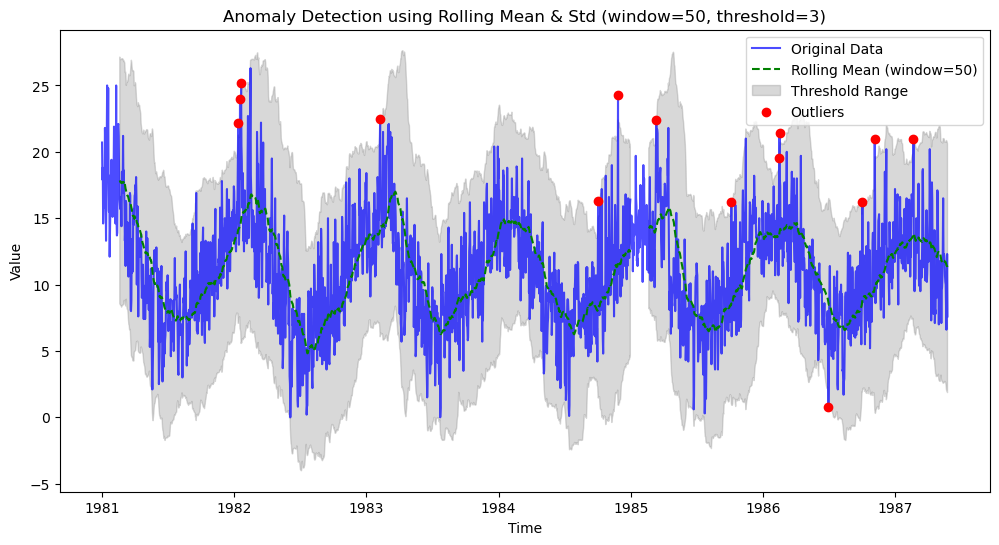

Detected 14 outliers.


In [201]:
outliers = anomaly_detection_rolling(train_data['temperatures'], 50)

* Fill

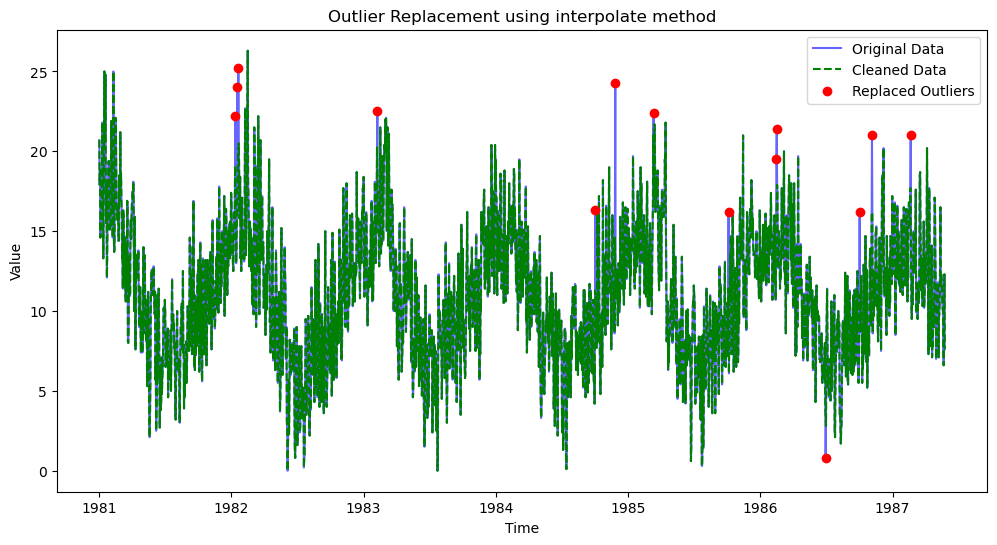

Replaced 14 outliers using 'interpolate' method.


In [202]:
train_cleaned = replace_and_fill_outliers(train_data, outliers, method='interpolate')

* Scale

In [203]:
train_scaled, scaler = normalize_data(train_cleaned, method=normalize)

* Init model

In [204]:
model = ARIMAModel(train_scaled)

* fit model

In [205]:
model.fit()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=10752.184, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=18157.507, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=11301.939, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=15665.457, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=10774.975, Time=0.44 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=10779.254, Time=0.72 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=10751.937, Time=1.30 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=10749.439, Time=0.71 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=11077.038, Time=0.26 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=10751.439, Time=0.78 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=11229.751, Time=0.18 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=10753.247, Time=0.80 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=10741.328, Time=2.25 sec
 ARIMA(2,0,1)(0,0,0)[0] i

* forecast

In [206]:
predictions, conf_int = model.predict(length_pred)

* Inverse scale

In [207]:
if scaler is not None:
    y_pred = inverse_scale(predictions, scaler)
    conf_int[:,0] = inverse_scale(conf_int[:,0], scaler)
    conf_int[:,1] = inverse_scale(conf_int[:,1], scaler)
else:
    y_pred = predictions

* Evaluate

In [208]:
df_metrics = compute_metrics(model, scaler, val_data.values, y_pred)
df_metrics

,Model,Scaler,Params,MAPE,RMSE,R2 Score,Execution Date
0,ARIMAModel,NoneType,"(3, 0, 1)",0.348458,3.888851,0.052914,15-02-2025


* Save results

In [209]:
# Save metrics
index = save_metrics_to_csv(df_metrics, LOG_RESULTS)
# Save plot
plot_forecast(train_data, val_data, y_pred, model, index=index, conf_int=conf_int)
pd.read_csv(LOG_RESULTS)

Metrics saved to ../models/log/metrics_results.csv
Plot saved to ../reports/results/_0_ARIMAModel.png


,Model,Scaler,Params,MAPE,RMSE,R2 Score,Execution Date
0,ARIMAModel,NoneType,"(3, 0, 1)",0.348458,3.888851,0.052914,15-02-2025
